In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from scipy import stats


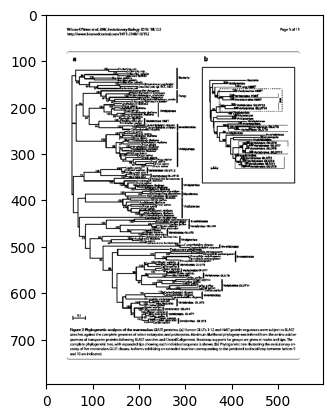

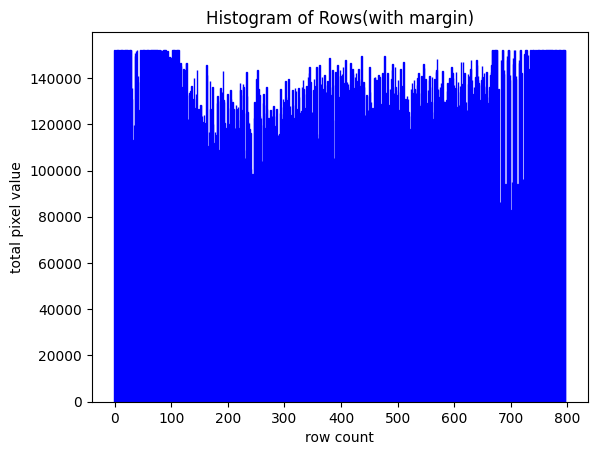

In [119]:
img = cv2.imread('paper9.png')
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(imgray, 200, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')
plt.show()

array = np.array(thresh)
array.shape

row_sums = np.sum(array, axis=1)


indices = np.arange(len(row_sums))

plt.bar(indices, row_sums, edgecolor='blue')

plt.title('Histogram of Rows(with margin)')
plt.xlabel('row count')
plt.ylabel('total pixel value')

plt.show()

In [120]:
def trim_white_margins_lr(pixel_array):
    col_sums = np.sum(pixel_array, axis=0)
    num_rows = pixel_array.shape[0]
    white_col_sum = 255 * num_rows

    # Find the first non-white column from the left
    start_index = 0
    while start_index < len(col_sums) and col_sums[start_index] == white_col_sum:
        start_index += 1

    # Find the first non-white column from the right
    end_index = len(col_sums) - 1
    while end_index >= 0 and col_sums[end_index] == white_col_sum:
        end_index -= 1

    # Trim the pixel array
    col_trimmed_array = pixel_array[:, start_index:end_index+1]

    return col_trimmed_array,start_index

# row_trimmed_array,top_margin = trim_white_margins(array)
side_marginless_array,left_margin = trim_white_margins_lr(array)

# print("Side_Marginless Array:")
# print(side_marginless_array)
print(side_marginless_array.shape)

#Top Margin
# top_margin = array.shape[0] - marginless_array.shape[0]
# print(top_margin)
print("Left Margin:", left_margin)
print()




def col_sum(array):
    return np.sum(array, axis=0), 255 * array.shape[0]

def identify_col_gaps(col_sum, white_col_sum):
    gap_indices = []
    in_gap = False
    current_gap_start = None

    for col_index, value in enumerate(col_sum):
        if value == white_col_sum:
            if not in_gap:
                # Start a new gap
                in_gap = True
                current_gap_start = col_index
        else:
            if in_gap:
                # End the current gap
                in_gap = False
                gap_indices.append((current_gap_start, col_index - 1))
                current_gap_start = None

    # Handle the case where the gap goes till the end of the array
    if in_gap:
        gap_indices.append((current_gap_start, len(col_sum) - 1))

    return gap_indices


def divide_image(image, gap_indices):
    parts = []
    start = 0
    for gap_start, gap_end in gap_indices:
        parts.append((start, gap_start))
        start = gap_end
    parts.append((start, image.shape[1]))
    return parts

    if len(parts) == 0:
      parts.append((0, image.shape[1]))


col_sum, white_col_sum = col_sum(side_marginless_array)
gap_indices = identify_col_gaps(col_sum, white_col_sum)
print("Gap between columns:", gap_indices)
print()


all_cols = divide_image(side_marginless_array, gap_indices)
print("Text columns:", all_cols)



(797, 502)
Left Margin: 45

Gap between columns: []

Text columns: [(0, 502)]


5.4
Average Line Gap Height: 2
Significant Gaps (row indices): [(18, 51), (55, 61), (72, 84), (637, 647)]
Part from rows 61 to 72 likely contains figures.


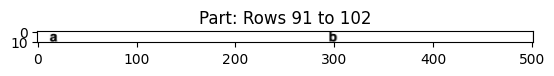

Part from rows 84 to 637 likely contains figures.


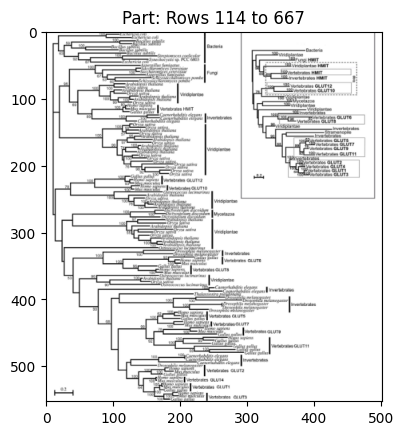

In [121]:
marginless_arrays_processed =[]
top_margin_array =[]

for col in all_cols:

  def trim_white_margins(pixel_array):
    row_sums = np.sum(pixel_array, axis=1)
    num_columns = pixel_array.shape[1]
    white_row_sum = 255 * num_columns

    # Find the first non-white row from the top
    start_index = 0
    while start_index < len(row_sums) and row_sums[start_index] == white_row_sum:
        start_index += 1

    # Find the first non-white row from the bottom
    end_index = len(row_sums) - 1
    while end_index >= 0 and row_sums[end_index] == white_row_sum:
        end_index -= 1

    # Trim the pixel array
    row_trimmed_array = pixel_array[start_index:end_index+1, :]

    return row_trimmed_array,start_index


  marginless_array,top_margin = trim_white_margins(side_marginless_array[:, col[0]:col[1]])
  # print("Top margin:",top_margin)

  # sliced_array = marginless_array[:, col[0]:col[1]]
  # print(sliced_array.shape)
  marginless_arrays_processed.append(marginless_array)
  top_margin_array.append(top_margin)

# for marginless_array_processed in marginless_arrays_processed:
for i, marginless_array_processed in enumerate(marginless_arrays_processed):


  def convert_non_255_to_zero(marginless_array_processed):
    marginless_array_row_sums = np.sum(marginless_array_processed, axis=1)
    new_arr = np.where(marginless_array_row_sums != 255*marginless_array_processed.shape[1], 0, marginless_array_row_sums)
    return new_arr

  # Convert non-255 values to 0 and store in another array
  marginless_array_improved_row_sum = convert_non_255_to_zero(marginless_array_processed)



  def calculate_row_sums(image, threshold=255):
      num_rows, num_columns = image.shape
      white_row_sum = threshold * num_columns
      row_sums = np.sum(image, axis=1)
      return row_sums, white_row_sum

  def identify_line_gaps(row_sums, white_row_sum):
      white_space_lengths = []
      current_length = 0

      for value in row_sums:
          if value == white_row_sum:
              current_length += 1
          else:
              if current_length > 0:
                  white_space_lengths.append(current_length)
                  current_length = 0

      if current_length > 0:
          white_space_lengths.append(current_length)

      if white_space_lengths:
        mode_result = stats.mode(white_space_lengths)
          # Check if the mode result contains any mode value
        if mode_result.mode.size > 0:
            average_line_gap = mode_result.mode
        #  average_line_gap = stats.mode(white_space_lengths).mode[0]#mode
      else:
          average_line_gap = 0

      return average_line_gap, white_space_lengths #mode

  def find_significant_gaps(row_sums, white_row_sum, average_line_gap, gap_multiplier=2.7):#mode
      significant_gaps = []
      current_length = 0
      significant_threshold = average_line_gap * gap_multiplier #mode
      print(significant_threshold)

      for i, value in enumerate(row_sums):
          if value == white_row_sum:
              current_length += 1
          else:
              if current_length >= significant_threshold:
                  significant_gaps.append((i - current_length, i))
              current_length = 0

      if current_length > significant_threshold:
          significant_gaps.append((len(row_sums) - current_length, len(row_sums)))

      return significant_gaps
      #print(significant_gaps)

  def divide_image(image, significant_gaps):
      start = 0
      for gap_start, gap_end in significant_gaps:
          parts.append((start, gap_start))
          start = gap_end
      parts.append((start, image.shape[0]))
      # print(start, image.shape[0])
      return parts
  row_sums, white_row_sum = calculate_row_sums(marginless_array_processed)
  average_line_gap, white_space_lengths = identify_line_gaps(row_sums, white_row_sum)
  significant_gaps = find_significant_gaps(row_sums, white_row_sum, average_line_gap) #mode

  parts = []
  print("Average Line Gap Height:", average_line_gap) #mode

  print("Significant Gaps (row indices):", significant_gaps)
  #print("Line gap mode count", mode_count)


  parts = divide_image(marginless_array_processed, significant_gaps)
  # print(parts)



####### prints a pic of every part

  # def display_image_parts_separately(image, parts):
  #     for i, (start, end) in enumerate(parts):
  #         part = image[start:end, 0:image.shape[1]]
  #         plt.figure(figsize=(10, 5))
  #         plt.imshow(part, cmap='gray')
  #         plt.axis('off')
  #         plt.title(f'Part {i + 1}')
  #         plt.show()

  # display_image_parts_separately(marginless_array_processed, parts)




  # Function to analyze texture using Local Binary Patterns (LBP)
  def analyze_texture(image_part, P=8, R=1):
      lbp = local_binary_pattern(image_part, P, R, method='uniform')
      return lbp

  # Function to determine if the texture is significant
  def has_significant_texture(lbp, threshold=0.75):
      P = 8
      (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
      hist = hist.astype("float")
      hist /= (hist.sum() + 1e-7)  # Normalize the histogram


      # plt.figure(figsize=(10, 5))
      # plt.bar(np.arange(0, P + 2), hist, width=0.7, color='blue', alpha=0.7)
      # plt.title("LBP Histogram")
      # plt.xlabel("LBP Value")
      # plt.ylabel("Normalized Frequency")
      # plt.show()

      return hist.max() > threshold

# def display_image_parts(image, parts):
#     for i, (start, end) in enumerate(parts):
#         part = image[start:end, 0:image.shape[1]]
#         plt.figure()
#         plt.imshow(part, cmap='gray')
#         plt.title(f'Part {i+1}: Rows {start} to {end}')
#         plt.show()


# Load the image (assuming it's already loaded as 'image')
# Assuming 'image' is a 2D numpy array (grayscale)

  for start, end in parts:
      part = marginless_array_processed[start:end, 0:marginless_array_processed.shape[1]]
      # print(part.shape)
      # if np.all
      lbp = analyze_texture(part)
      if has_significant_texture(lbp):
          print(f"Part from rows {start} to {end} likely contains figures.")
          # print(f"Part from rows {start+top_margin} to {end+top_margin} likely contains figures.")

          # plt.figure()
          # plt.imshow(part, cmap='gray')
          # plt.title(f'Part: Rows {start} to {end}')
          # plt.show()
          if i == 0:
            final_part = img[start+top_margin_array[i]:end+ top_margin_array[i], left_margin:marginless_array_processed.shape[1]+left_margin]
          else:
            x =all_cols[i][0] - all_cols[i-1][1]
            last_col_width =all_cols[i-1][1]
            final_part = img[start+top_margin_array[i]:end+ top_margin_array[i], left_margin+last_col_width+x:marginless_array_processed.shape[1]+left_margin+last_col_width+x]
          plt.figure()
          plt.imshow(final_part, cmap='gray')
          plt.title(f'Part: Rows {start+top_margin_array[i]} to {end+top_margin_array[i]}')
          plt.show()






